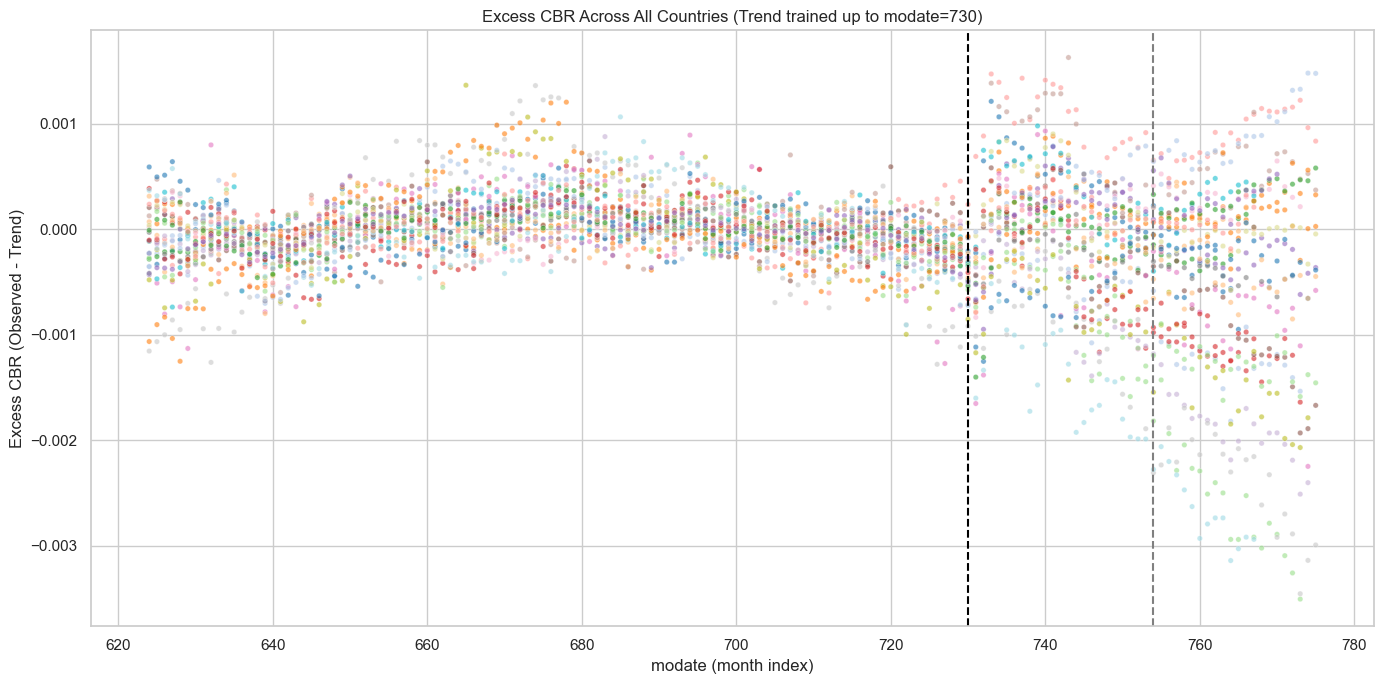

In [1]:
# STEP 1: Import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# STEP 2: Load your dataset
df = pd.read_csv('cbr2012.csv')

# STEP 3: Estimate linear trend up to modate=730 and calculate excess CBR
records_fixed_730 = []

for country in df['countrycode'].unique():
    df_country = df[df['countrycode'] == country].sort_values('modate')
    
    # Train model up to modate=730
    train_df = df_country[df_country['modate'] <= 730]
    if len(train_df) < 2:
        continue
    
    X_train = sm.add_constant(train_df['modate'])
    y_train = train_df['CBR']
    model_fixed_730 = sm.OLS(y_train, X_train).fit()
    
    # Predict across the whole dataset
    X_full = sm.add_constant(df_country['modate'])
    df_country['predicted_cbr_730'] = model_fixed_730.predict(X_full)
    df_country['excess_cbr_730'] = df_country['CBR'] - df_country['predicted_cbr_730']
    
    records_fixed_730.append(df_country[['modate', 'countrycode', 'year', 'month', 'CBR', 'predicted_cbr_730', 'excess_cbr_730']])

# Combine results into one DataFrame
excess_fixed_730_df = pd.concat(records_fixed_730, ignore_index=True)

# STEP 4: Plot scatter plot (excess CBR for all countries)
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

sns.scatterplot(
    data=excess_fixed_730_df,
    x='modate',
    y='excess_cbr_730',
    hue='countrycode',
    palette='tab20',
    legend=False,
    s=15,
    alpha=0.6
)

# Add vertical reference lines
plt.axvline(x=730, color='black', linestyle='--', label='modate = 730 (Jan 2020)')
plt.axvline(x=754, color='gray', linestyle='--', label='modate = 754 (Jan 2022)')

# Labels and title
plt.xlabel('modate (month index)')
plt.ylabel('Excess CBR (Observed - Trend)')
plt.title('Excess CBR Across All Countries (Trend trained up to modate=730)')

plt.tight_layout()
plt.show()


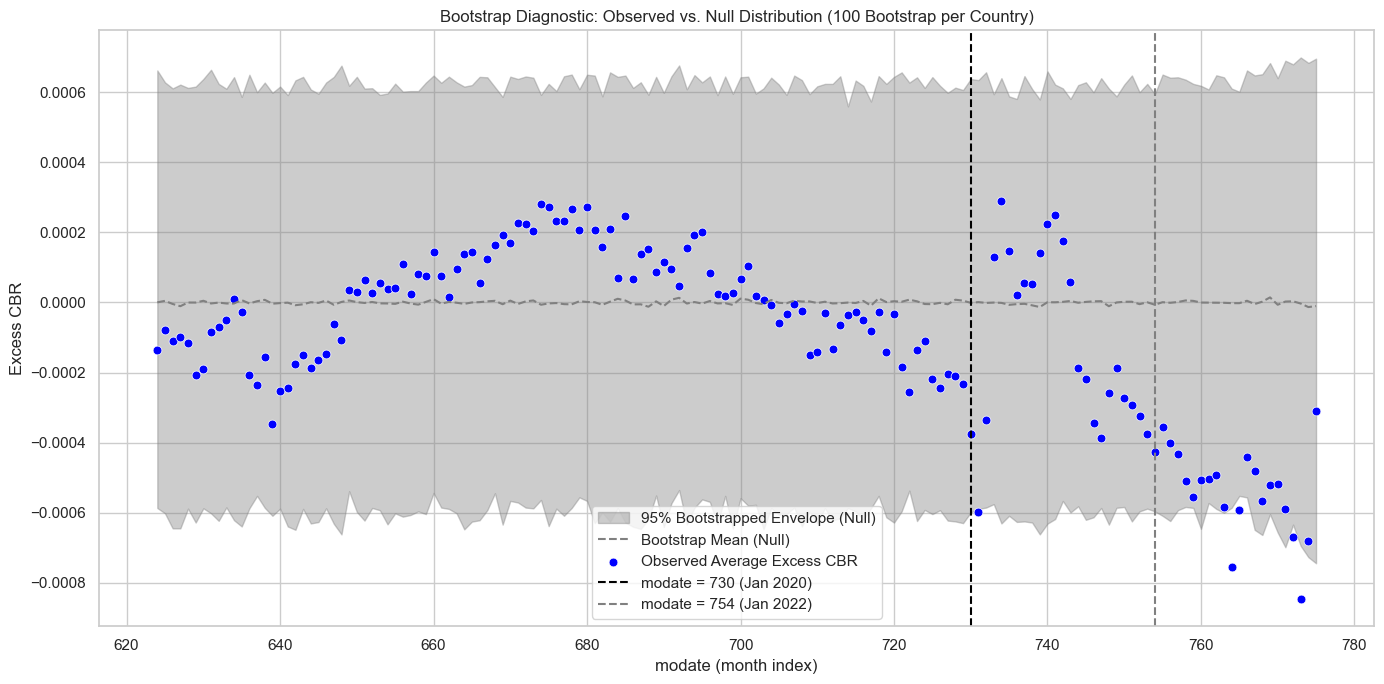

In [5]:
# STEP 1: Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# STEP 2: Load the dataset
df = pd.read_csv(r"C:\Users\CavalliNic\Downloads\cbr2012.csv")

# STEP 3: Estimate linear trend up to modate=730
records_fixed_730 = []

for country in df['countrycode'].unique():
    df_country = df[df['countrycode'] == country].sort_values('modate')

    train_df = df_country[df_country['modate'] <= 730]
    if len(train_df) < 2:
        continue

    X_train = sm.add_constant(train_df['modate'])
    model_fixed_730 = sm.OLS(train_df['CBR'], X_train).fit()

    # Predict full dataset
    X_full = sm.add_constant(df_country['modate'])
    df_country['predicted_cbr'] = model_fixed_730.predict(X_full)
    df_country['excess_cbr'] = df_country['CBR'] - df_country['predicted_cbr']

    records_fixed_730.append(df_country[['modate', 'countrycode', 'CBR', 'predicted_cbr', 'excess_cbr']])

excess_df = pd.concat(records_fixed_730, ignore_index=True)

# STEP 4: Bootstrap residuals around the null for each country
n_bootstraps = 100
bootstrap_results = []

for country in excess_df['countrycode'].unique():
    df_country = excess_df[excess_df['countrycode'] == country].copy()
    residuals = df_country[df_country['modate'] <= 730]['excess_cbr'].values
    modates = df_country['modate'].values
    predicted = df_country['predicted_cbr'].values

    for b in range(n_bootstraps):
        # Bootstrap residuals with replacement
        resampled_residuals = np.random.choice(residuals, size=len(predicted), replace=True)

        # Create bootstrapped excess CBR series
        bootstrapped_cbr = predicted + resampled_residuals
        boot_excess_cbr = bootstrapped_cbr - predicted  # residuals by construction

        bootstrap_results.append(pd.DataFrame({
            'modate': modates,
            'countrycode': country,
            'bootstrap': b,
            'boot_excess_cbr': boot_excess_cbr
        }))

# Combine all bootstraps
bootstrap_df = pd.concat(bootstrap_results, ignore_index=True)

# STEP 5: Aggregate bootstraps to get envelope (e.g., 2.5% and 97.5% quantiles)
bootstrap_summary = bootstrap_df.groupby('modate')['boot_excess_cbr'].agg(
    lower=lambda x: np.percentile(x, 2.5),
    upper=lambda x: np.percentile(x, 97.5),
    mean='mean'
).reset_index()

# STEP 6: Compute actual average excess_cbr across countries
actual_avg_excess = excess_df.groupby('modate')['excess_cbr'].mean().reset_index()

# STEP 7: Plot observed excess CBR vs. bootstrapped envelope
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot bootstrapped envelope
plt.fill_between(
    bootstrap_summary['modate'],
    bootstrap_summary['lower'],
    bootstrap_summary['upper'],
    color='gray', alpha=0.4,
    label='95% Bootstrapped Envelope (Null)'
)

# Plot bootstrapped mean
plt.plot(
    bootstrap_summary['modate'],
    bootstrap_summary['mean'],
    color='gray', linestyle='--',
    label='Bootstrap Mean (Null)'
)

# Plot actual observed average excess CBR
sns.scatterplot(
    data=actual_avg_excess,
    x='modate',
    y='excess_cbr',
    color='blue',
    s=40,
    label='Observed Average Excess CBR'
)

# Reference vertical lines
plt.axvline(x=730, color='black', linestyle='--', label='modate = 730 (Jan 2020)')
plt.axvline(x=754, color='gray', linestyle='--', label='modate = 754 (Jan 2022)')

# Labels and legend
plt.xlabel('modate (month index)')
plt.ylabel('Excess CBR')
plt.title('Bootstrap Diagnostic: Observed vs. Null Distribution (100 Bootstrap per Country)')
plt.legend()

plt.tight_layout()
plt.show()


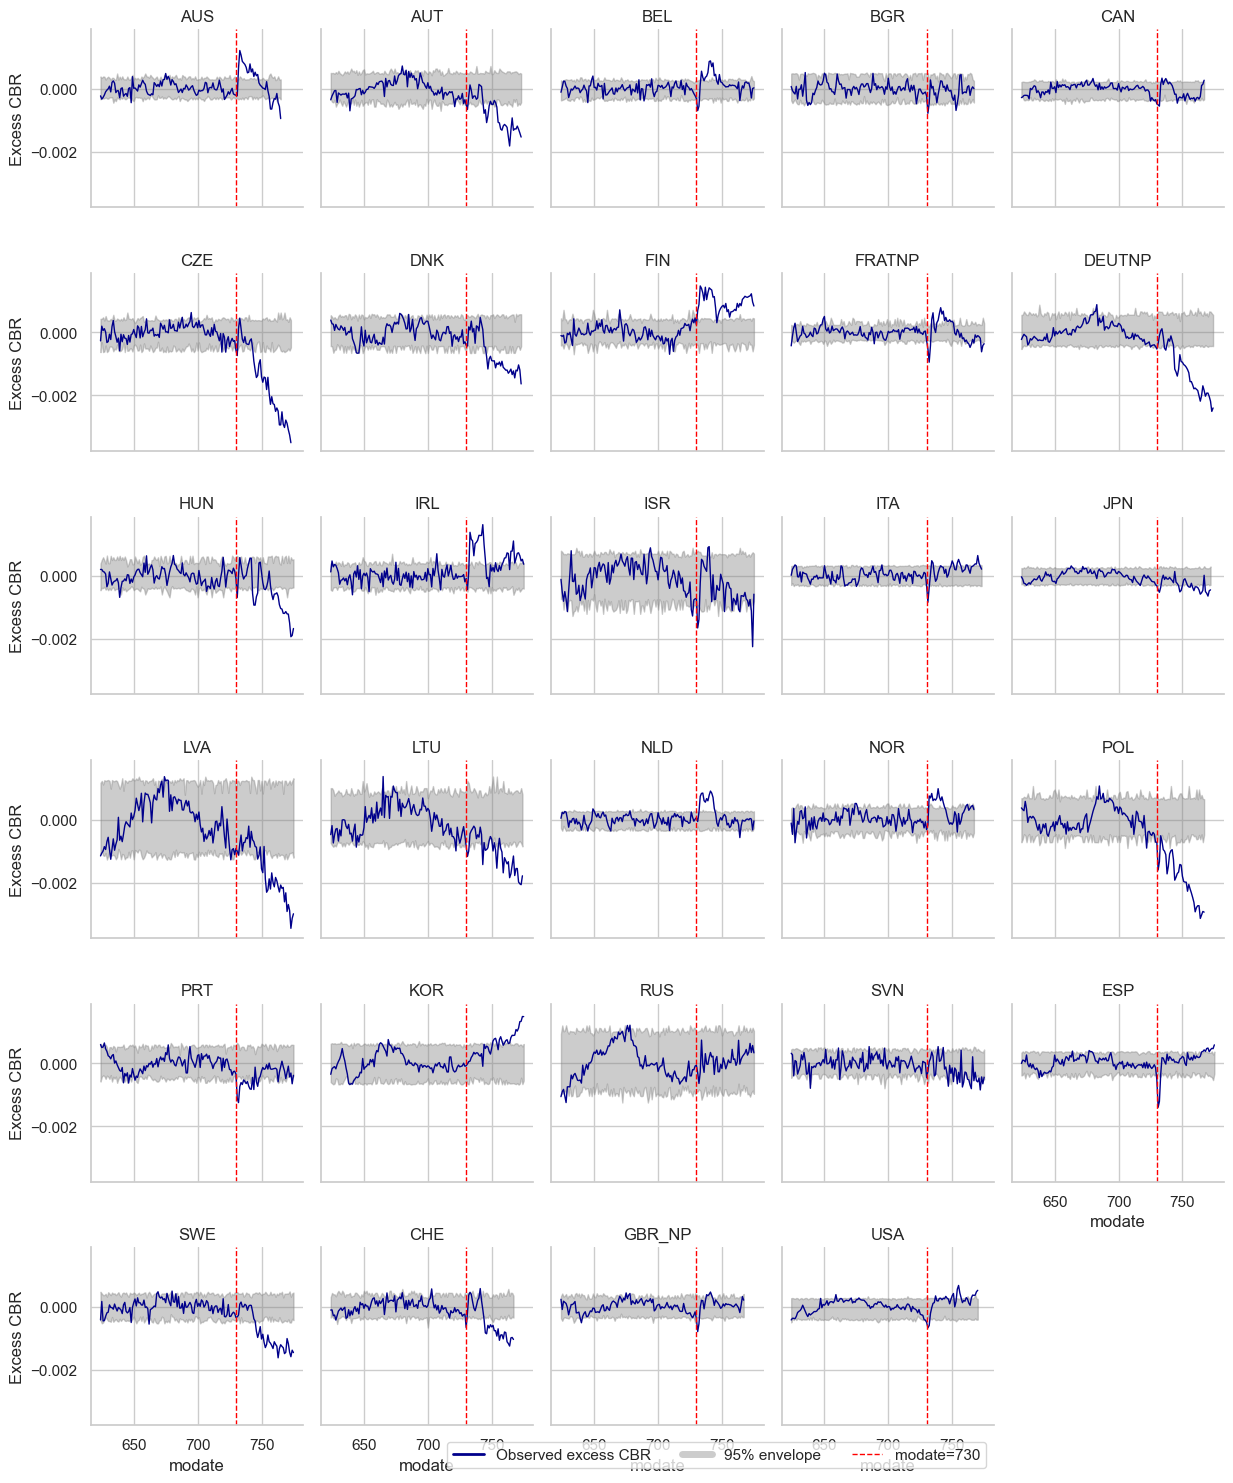

In [7]:
# STEP 1: Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# STEP 2: Load dataset
df = pd.read_csv(r"C:\Users\CavalliNic\Downloads\cbr2012.csv")

# STEP 3: Estimate linear trend (modate <=730) and calculate excess CBR
excess_records = []

for country in df['countrycode'].unique():
    df_country = df[df['countrycode'] == country].sort_values('modate')

    # Fit linear model (up to modate=730)
    train_df = df_country[df_country['modate'] <= 730]
    if len(train_df) < 2:
        continue

    X_train = sm.add_constant(train_df['modate'])
    model = sm.OLS(train_df['CBR'], X_train).fit()

    # Predict full period
    X_full = sm.add_constant(df_country['modate'])
    df_country['predicted_cbr'] = model.predict(X_full)
    df_country['excess_cbr'] = df_country['CBR'] - df_country['predicted_cbr']
    excess_records.append(df_country[['modate', 'countrycode', 'excess_cbr', 'predicted_cbr']])

excess_df = pd.concat(excess_records, ignore_index=True)

# STEP 4: Bootstrap residuals (per country, 100 bootstraps)
bootstrap_envelopes = []

for country in excess_df['countrycode'].unique():
    df_country = excess_df[excess_df['countrycode'] == country]
    residuals = df_country[df_country['modate'] <= 730]['excess_cbr'].values
    modates = df_country['modate'].values
    predicted = df_country['predicted_cbr'].values

    bootstrap_samples = []

    for _ in range(100):
        sampled_residuals = np.random.choice(residuals, len(predicted), replace=True)
        boot_excess = sampled_residuals
        bootstrap_samples.append(boot_excess)

    # Compute bootstrap envelopes
    bootstrap_array = np.array(bootstrap_samples)
    lower = np.percentile(bootstrap_array, 2.5, axis=0)
    upper = np.percentile(bootstrap_array, 97.5, axis=0)

    bootstrap_envelopes.append(pd.DataFrame({
        'modate': modates,
        'countrycode': country,
        'lower': lower,
        'upper': upper,
        'observed': df_country['excess_cbr'].values
    }))

envelopes_df = pd.concat(bootstrap_envelopes)

# STEP 5: Plot using facet-grid by country
g = sns.FacetGrid(envelopes_df, col="countrycode", col_wrap=5, height=2.5, sharey=True)

# Add bootstrap envelope and actual data
def plot_envelope(data, color, **kwargs):
    plt.fill_between(data['modate'], data['lower'], data['upper'], color='gray', alpha=0.4, label='95% envelope')
    plt.plot(data['modate'], data['observed'], color='darkblue', linewidth=1, label='Observed excess CBR')
    plt.axvline(730, linestyle='--', color='red', linewidth=1)

g.map_dataframe(plot_envelope)

# Adjust plot details
g.set_axis_labels("modate", "Excess CBR")
g.set_titles(col_template="{col_name}")
plt.tight_layout()

# Add global legend manually
handles = [plt.Line2D([0], [0], color='darkblue', lw=2, label='Observed excess CBR'),
           plt.Line2D([0], [0], color='gray', lw=5, alpha=0.4, label='95% envelope'),
           plt.Line2D([0], [0], color='red', linestyle='--', lw=1, label='modate=730')]
plt.legend(handles=handles, bbox_to_anchor=(1, -0.05), ncol=3)

plt.show()


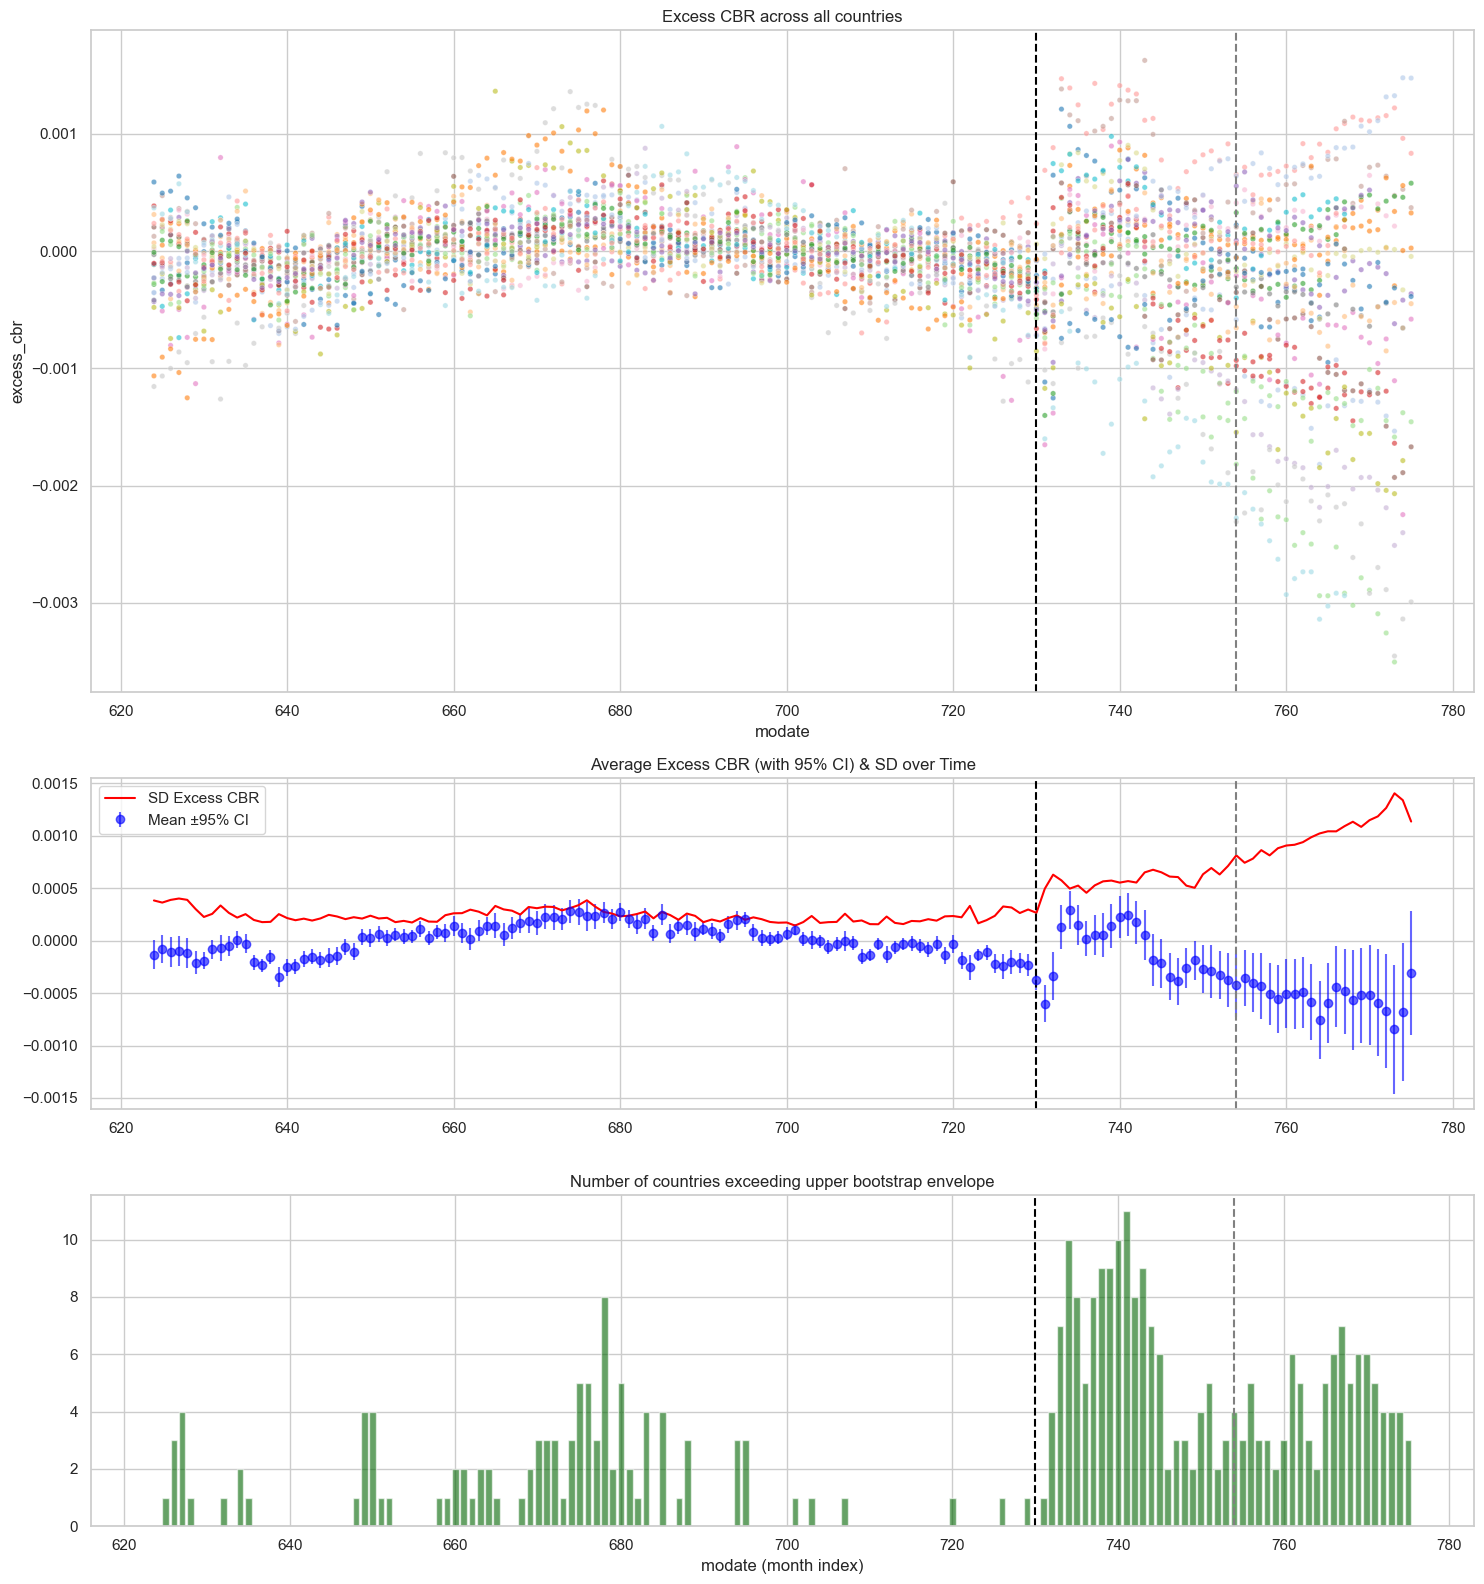

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load dataset
df = pd.read_csv(r"C:\Users\CavalliNic\Downloads\cbr2012.csv")

# Estimate trend and excess CBR (linear, modate <=730)
records, envelopes = [], []
for country in df['countrycode'].unique():
    df_country = df[df['countrycode'] == country].sort_values('modate')
    train_df = df_country[df_country['modate'] <= 730]
    if len(train_df) < 2:
        continue
    X_train = sm.add_constant(train_df['modate'])
    model = sm.OLS(train_df['CBR'], X_train).fit()
    X_full = sm.add_constant(df_country['modate'])
    df_country['predicted_cbr'] = model.predict(X_full)
    df_country['excess_cbr'] = df_country['CBR'] - df_country['predicted_cbr']
    records.append(df_country[['modate', 'countrycode', 'excess_cbr', 'predicted_cbr']])

excess_df = pd.concat(records, ignore_index=True)

# Compute bootstrap envelopes (100 bootstraps per country)
bootstrap_results = []
for country in excess_df['countrycode'].unique():
    df_country = excess_df[excess_df['countrycode'] == country]
    residuals = df_country[df_country['modate'] <= 730]['excess_cbr'].values
    modates = df_country['modate'].values
    predicted = df_country['predicted_cbr'].values

    bootstraps = np.array([
        np.random.choice(residuals, len(predicted), replace=True)
        for _ in range(100)
    ])
    lower = np.percentile(bootstraps, 2.5, axis=0)
    upper = np.percentile(bootstraps, 97.5, axis=0)

    envelopes.append(pd.DataFrame({
        'modate': modates,
        'countrycode': country,
        'lower': lower,
        'upper': upper,
        'observed': df_country['excess_cbr'].values
    }))

envelopes_df = pd.concat(envelopes, ignore_index=True)

# Count countries above upper bootstrap envelope each month
envelopes_df['above_upper'] = envelopes_df['observed'] > envelopes_df['upper']
above_count = envelopes_df.groupby('modate')['above_upper'].sum().reset_index()

# Compute average and CI for excess_cbr across countries
agg_df = excess_df.groupby('modate').agg(
    mean_excess=('excess_cbr', 'mean'),
    sd_excess=('excess_cbr', 'std'),
    count=('excess_cbr', 'size')
).reset_index()
agg_df['sem'] = agg_df['sd_excess'] / np.sqrt(agg_df['count'])
agg_df['ci_lower'] = agg_df['mean_excess'] - 1.96 * agg_df['sem']
agg_df['ci_upper'] = agg_df['mean_excess'] + 1.96 * agg_df['sem']

# Start plotting stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(15, 16),
    gridspec_kw={'height_ratios': [2, 1, 1]}
)
sns.set(style="whitegrid")

# --- Top plot: Excess CBR scatter (all countries) ---
sns.scatterplot(
    data=excess_df, x='modate', y='excess_cbr', hue='countrycode',
    palette='tab20', legend=False, s=15, alpha=0.6, ax=ax1
)
ax1.axvline(730, linestyle='--', color='black')
ax1.axvline(754, linestyle='--', color='gray')
ax1.set_title('Excess CBR across all countries')

# --- Middle plot: Mean excess CBR + CI, and SD ---
ax2.errorbar(agg_df['modate'], agg_df['mean_excess'], 
             yerr=1.96*agg_df['sem'], fmt='o', 
             color='blue', alpha=0.6, label='Mean ±95% CI')
ax2.plot(agg_df['modate'], agg_df['sd_excess'], 
         color='red', linestyle='-', linewidth=1.5, label='SD Excess CBR')

ax2.axvline(730, linestyle='--', color='black')
ax2.axvline(754, linestyle='--', color='gray')
ax2.set_title('Average Excess CBR (with 95% CI) & SD over Time')
ax2.legend()

# --- Bottom plot: Number of countries above bootstrap envelope ---
ax3.bar(above_count['modate'], above_count['above_upper'], color='darkgreen', alpha=0.6)
ax3.axvline(730, linestyle='--', color='black')
ax3.axvline(754, linestyle='--', color='gray')
ax3.set_title('Number of countries exceeding upper bootstrap envelope')
ax3.set_xlabel('modate (month index)')

plt.tight_layout()
plt.show()


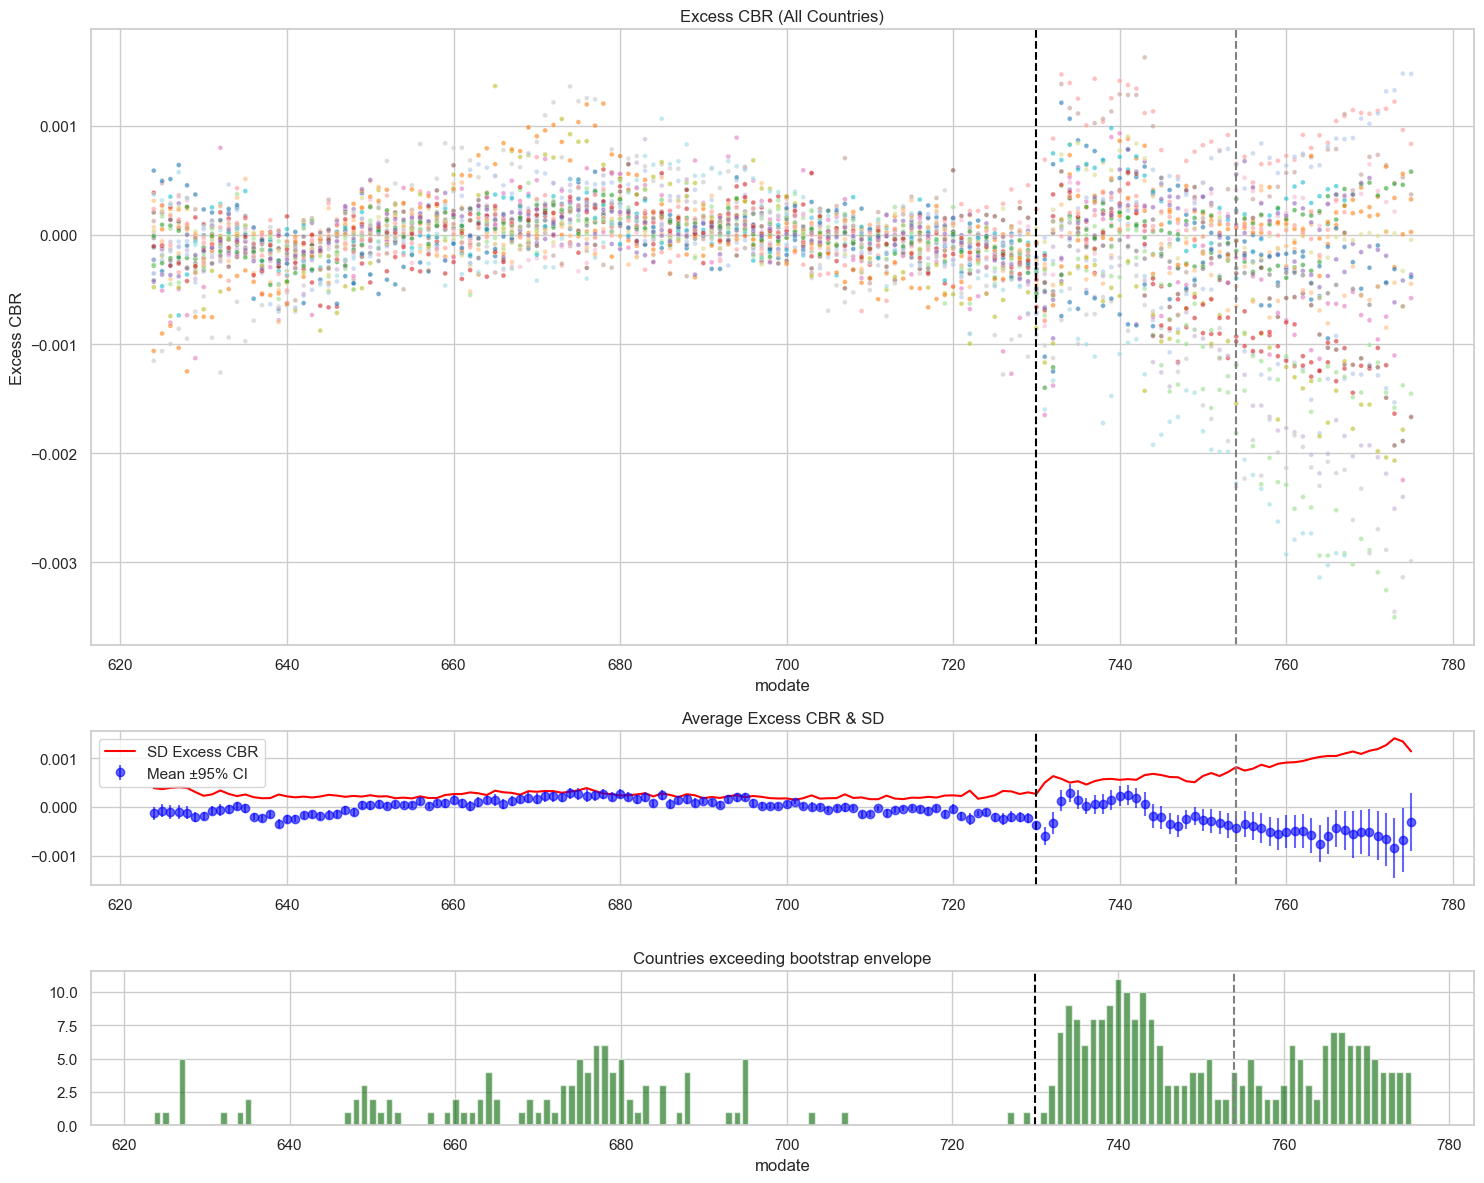

In [19]:
# --- IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- LOAD DATA ---
df = pd.read_csv(r"C:\Users\CavalliNic\Downloads\cbr2012.csv")

# --- ESTIMATE EXCESS_CBR (linear trend trained to modate=730) ---
records, envelopes = [], []
for country in df['countrycode'].unique():
    df_country = df[df['countrycode'] == country].sort_values('modate')
    train_df = df_country[df_country['modate'] <= 730]
    if len(train_df) < 2: continue
    model = sm.OLS(train_df['CBR'], sm.add_constant(train_df['modate'])).fit()
    df_country['predicted_cbr'] = model.predict(sm.add_constant(df_country['modate']))
    df_country['excess_cbr'] = df_country['CBR'] - df_country['predicted_cbr']
    records.append(df_country[['modate', 'countrycode', 'year', 'excess_cbr', 'predicted_cbr']])
excess_df = pd.concat(records, ignore_index=True)

boot_envelopes = []
for country in excess_df['countrycode'].unique():
    df_c = excess_df[excess_df['countrycode'] == country].copy()
    train_resids = df_c[df_c['modate'] <= 730]['excess_cbr'].values
    full_length = len(df_c)

    # Bootstrap residuals to generate null distribution for full timeframe
    bootstraps = np.array([
        np.random.choice(train_resids, full_length, replace=True)
        for _ in range(100)
    ])
    lower = np.percentile(bootstraps, 2.5, axis=0)
    upper = np.percentile(bootstraps, 97.5, axis=0)
    
    boot_envelopes.append(pd.DataFrame({
        'modate': df_c['modate'],
        'countrycode': country,
        'lower': lower,
        'upper': upper,
        'observed': df_c['excess_cbr']
    }))
envelopes_df = pd.concat(boot_envelopes, ignore_index=True)

# Count countries above upper envelope
envelopes_df['above_upper'] = envelopes_df['observed'] > envelopes_df['upper']
above_count = envelopes_df.groupby('modate')['above_upper'].sum().reset_index()

# Aggregate stats (mean, CI, SD)
agg_df = excess_df.groupby('modate').agg(
    mean_excess=('excess_cbr', 'mean'),
    sd_excess=('excess_cbr', 'std'),
    count=('excess_cbr', 'size')
).reset_index()
agg_df['sem'] = agg_df['sd_excess'] / np.sqrt(agg_df['count'])
agg_df['ci_lower'] = agg_df['mean_excess'] - 1.96 * agg_df['sem']
agg_df['ci_upper'] = agg_df['mean_excess'] + 1.96 * agg_df['sem']

# --- STACKED 3-PANEL PLOT (Adjusted Heights) ---
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(15, 12),
    gridspec_kw={'height_ratios': [4, 1, 1]}
)
sns.set(style="whitegrid")

# Top: Excess CBR scatter (all countries)
sns.scatterplot(data=excess_df, x='modate', y='excess_cbr', hue='countrycode',
                palette='tab20', legend=False, s=12, alpha=0.6, ax=ax1)
ax1.axvline(730, linestyle='--', color='black')
ax1.axvline(754, linestyle='--', color='gray')
ax1.set_ylabel('Excess CBR')
ax1.set_title('Excess CBR (All Countries)')

# Middle: Mean excess CBR with CI, SD line
ax2.errorbar(agg_df['modate'], agg_df['mean_excess'], 
             yerr=1.96*agg_df['sem'], fmt='o', color='blue', alpha=0.6, label='Mean ±95% CI')
ax2.plot(agg_df['modate'], agg_df['sd_excess'], color='red', linestyle='-', linewidth=1.5, label='SD Excess CBR')
ax2.axvline(730, linestyle='--', color='black')
ax2.axvline(754, linestyle='--', color='gray')
ax2.legend()
ax2.set_title('Average Excess CBR & SD')

# Bottom: Countries above bootstrap envelope
ax3.bar(above_count['modate'], above_count['above_upper'], color='darkgreen', alpha=0.6)
ax3.axvline(730, linestyle='--', color='black')
ax3.axvline(754, linestyle='--', color='gray')
ax3.set_title('Countries exceeding bootstrap envelope')
ax3.set_xlabel('modate')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig(r"C:\Users\CavalliNic\Downloads\figure1.png", dpi=300, bbox_inches='tight')

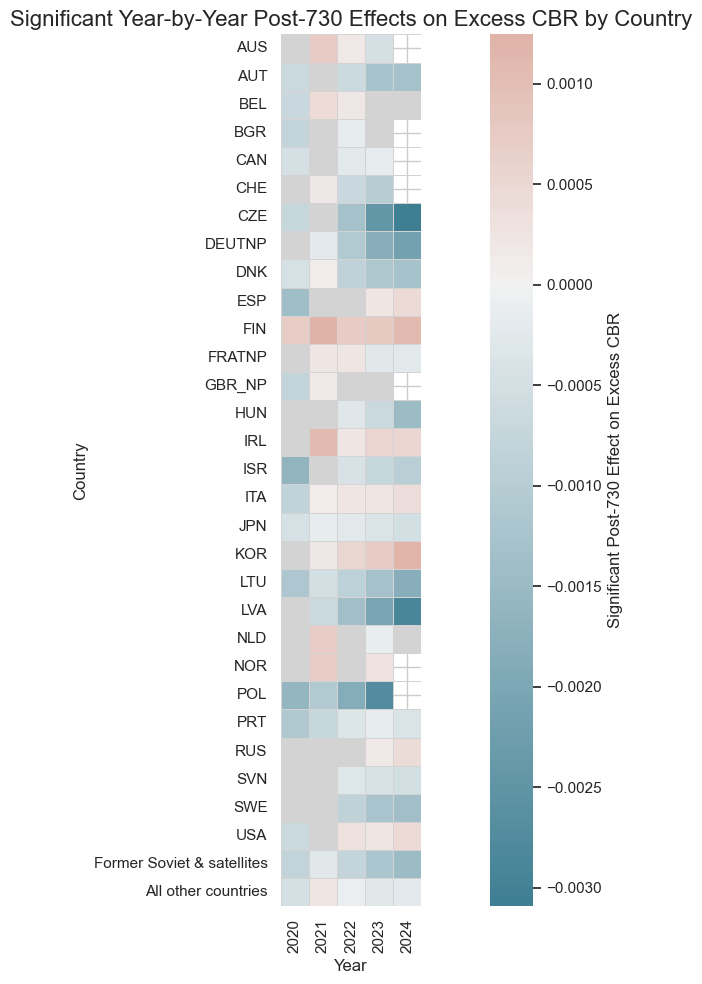

In [25]:
# Plot settings
plt.figure(figsize=(14, 10))

# Use a more attractive diverging color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot the heatmap
sns.heatmap(
    coef_pivot,
    mask=mask,  # Mask non-significant values
    cmap=cmap,
    center=0,
    linewidths=0.5,
    linecolor='lightgray',  # Subtle gridlines
    cbar_kws={'label': 'Significant Post-730 Effect on Excess CBR'},
    annot=False,  # No numeric annotations
    square=True,  # Make it a square plot for symmetry
    xticklabels=True,
    yticklabels=True,
    cbar=True
)

# Grey for non-significant coefficients
sns.heatmap(
    coef_pivot,
    mask=~mask,  # Non-significant values
    cmap=mcolors.ListedColormap(['lightgrey']),
    cbar=False,
    linewidths=0.5,
    linecolor='lightgray',  # Subtle gridlines
    annot=False,
    square=True
)

# Customize plot labels and title
plt.title('Significant Year-by-Year Post-730 Effects on Excess CBR by Country', fontsize=16)
plt.ylabel('Country', fontsize=12)
plt.xlabel('Year', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a specific path (e.g., Downloads folder)
output_path = r"C:\Users\CavalliNic\Downloads\excess_cbr_heatmap.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

# Display the plot
plt.show()


In [26]:
# Assuming excess_df is already defined and contains the necessary data

# Filter data by year periods
periods = {
    '2012-2019': (excess_df['year'] >= 2012) & (excess_df['year'] <= 2019),
    '2020-2021': (excess_df['year'] >= 2020) & (excess_df['year'] <= 2021),
    '2022-2024': (excess_df['year'] >= 2022) & (excess_df['year'] <= 2024)
}

# Calculate variance for each period
variance_by_period = {}

for period, condition in periods.items():
    period_data = excess_df[condition]
    # Calculate variance of excess CBR for each country in the period
    variance_by_period[period] = period_data.groupby('countrycode')['excess_cbr'].var().mean()

# Print average variances for each period
variance_by_period


{'2012-2019': 7.881049464965637e-08,
 '2020-2021': 1.3429627892210032e-07,
 '2022-2024': 1.2780465522471336e-07}